<a href="https://colab.research.google.com/github/N1colasFD/Unir_CODES/blob/main/Outliers_pynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
# ================================================
# OUTLIERS (ruido impulsivo / sal-y-pimienta)
# Diagnóstico y corrección NO ad hoc para Google Colab
# ================================================
# Qué hace:
# - Detecta outliers combinando extremos (cerca de 0/1) + umbral robusto en residuo (MAD).
# - Corrige SOLO los píxeles atípicos con mediana local 3→5→7 (preserva bordes).
# - Muestra: entrada, máscara, corregida e histogramas antes/después.
#
# Requisitos: OpenCV (cv2), NumPy, Matplotlib (ya vienen en Colab)

import cv2
import numpy as np
import matplotlib.pyplot as plt

# (Opcional) Subir imagen desde tu PC en Colab
def choose_image():
    try:
        from google.colab import files
        up = files.upload()
        assert len(up) > 0
        name = list(up.keys())[0]
        print(f"✔ Archivo subido: {name}")
        return f"/content/{name}"
    except Exception as e:
        raise RuntimeError("No se pudo subir la imagen. Usa una ruta local tipo '/content/mi_foto.jpg'.") from e

# -----------------------------
# Utilidades
# -----------------------------
def to_gray01(path):
    """
    Lee una imagen (BGR) y devuelve:
      - img01: GRAY float32 en [0,1]
      - bgr:   imagen color original (uint8)
    """
    bgr = cv2.imread(path, cv2.IMREAD_COLOR)
    if bgr is None:
        raise ValueError(f"No se pudo cargar la imagen: {path}")
    gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
    return gray.astype(np.float32) / 255.0, bgr

def residual(img01):
    """Residuo = imagen - blur suave (3x3). Alta frecuencia ≈ ruido/impulsos."""
    return img01 - cv2.GaussianBlur(img01, (3,3), 0)

def mad_sigma(x):
    """
    Estimación robusta de σ̂: σ̂ ≈ MAD/0.6745
    (MAD = mediana(|x - mediana(x)|))
    """
    r = x.ravel().astype(np.float32)
    med = np.median(r)
    MAD = np.median(np.abs(r - med))
    return float(MAD/0.6745 + 1e-8)

def fraction_of_extremes(img01, eps=0.02):
    """
    Fracción de píxeles muy cercanos a 0 o 1.
    Indicio de outliers (impulsos).
    """
    return float((img01 < eps).mean() + (img01 > 1-eps).mean())

# -----------------------------
# Detección y corrección OUTLIERS
# -----------------------------
def detect_outliers_mask(img01, k=3.0, eps=0.02):
    """
    Máscara de outliers combinando:
      - Extremos (0/1) con margen eps
      - Z-score robusto en residuo: |r - med(r)| > k·σ̂
    Devuelve: mask(bool), resid, sigma_hat, stats(dict)
    """
    r = residual(img01)
    s = mad_sigma(r)
    m_ext = (img01 < eps) | (img01 > 1-eps)
    m_rob = np.abs(r - np.median(r)) > (k * s)
    mask = (m_ext | m_rob)
    stats = {"sigma_hat": s, "extreme_frac": float(m_ext.mean()), "k": k, "eps": eps}
    return mask, r, s, stats

def replace_with_local_median(img01, mask, wins=(3,5,7)):
    """
    Reemplaza SOLO los píxeles marcados por mediana local.
    Secuencia 3→5→7 si aún persisten. Evita suavizado global.
    """
    out = img01.copy()
    x8 = (out*255).astype(np.uint8)
    for w in wins:
        med = cv2.medianBlur(x8, w).astype(np.float32)/255.0
        out[mask] = med[mask]
        x8 = (out*255).astype(np.uint8)
    return np.clip(out, 0, 1)

# (Opcional) versión color: corrige solo en máscara
def replace_with_local_median_color(bgr, mask, wins=(3,5,7)):
    out = bgr.copy()
    mask3 = np.repeat(mask[..., None], 3, axis=2)
    for w in wins:
        med = cv2.medianBlur(out, w)
        out[mask3] = med[mask3]
    return out

# -----------------------------
# (Opcional) Simular outliers
# -----------------------------
def simulate_outliers(img01, K=300, seed=42):
    """
    Inyecta K impulsos 0/1 aleatorios en una imagen [0,1] (para pruebas).
    """
    rng = np.random.default_rng(seed)
    H, W = img01.shape
    K = min(K, H*W)
    idx = rng.choice(H*W, size=K, replace=False)
    vals = img01.ravel()[idx]
    sp = img01.copy().ravel()
    sp[idx[vals < 0.5]] = 1.0  # "sal"
    sp[idx[vals >= 0.5]] = 0.0 # "pimienta"
    return sp.reshape(H, W)

# -----------------------------
# DEMO
# -----------------------------
def run_demo(image_path="/content/padre.jpg", simulate=False, K=300, show_color=False,
             k=3.0, eps=0.02):
    """
    Ejecuta SOLO OUTLIERS sobre la imagen dada.
      - simulate=True: inyecta outliers si tu imagen está "limpia"
      - show_color=True: aplica corrección también a color (usando la máscara)
      - k, eps: sensibilidad del detector (sube k o baja eps si hay falsos positivos)
    """
    img01, bgr = to_gray01(image_path)
    test = simulate_outliers(img01, K=K) if simulate else img01

    mask, r, s, stats = detect_outliers_mask(test, k=k, eps=eps)
    corrected = replace_with_local_median(test, mask, wins=(3,5,7))

    print(f"σ̂(residuo) = {s:.4f}  (~ {s*255:.1f} niveles 8-bit)")
    print(f"Fracción de extremos = {stats['extreme_frac']*100:.2f}%  |  k={stats['k']}  eps={stats['eps']}")
    print(f"Pixeles marcados como outliers: {mask.sum()}  ({mask.mean()*100:.2f} % de la imagen)")

    # Visualización: entrada, máscara, corregida (GRIS)
    plt.figure(figsize=(14,4))
    plt.subplot(1,3,1); plt.imshow(test, cmap='gray'); plt.title('Entrada'); plt.axis('off')
    plt.subplot(1,3,2); plt.imshow(mask, cmap='gray'); plt.title('Máscara de outliers'); plt.axis('off')
    plt.subplot(1,3,3); plt.imshow(corrected, cmap='gray'); plt.title('Corregida (mediana local)'); plt.axis('off')
    plt.tight_layout(); plt.show()

    # Histogramas antes/después (GRIS)
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1); plt.hist(test.ravel(), bins=256, range=(0,1), density=True); plt.title('Hist intensidades (entrada)')
    plt.subplot(1,2,2); plt.hist(corrected.ravel(), bins=256, range=(0,1), density=True); plt.title('Hist intensidades (corregida)')
    plt.tight_layout(); plt.show()

    # (Opcional) Color
    if show_color:
        out_color = replace_with_local_median_color(bgr, mask, wins=(3,5,7))
        plt.figure(figsize=(12,4))
        plt.subplot(1,2,1); plt.imshow(cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)); plt.title('Color (original)'); plt.axis('off')
        plt.subplot(1,2,2); plt.imshow(cv2.cvtColor(out_color, cv2.COLOR_BGR2RGB)); plt.title('Color (corregida en máscara)'); plt.axis('off')
        plt.tight_layout(); plt.show()


Saving Tranvia.jpg to Tranvia (1).jpg
✔ Archivo subido: Tranvia (1).jpg
σ̂(residuo) = 0.0196  (~ 5.0 niveles 8-bit)
Fracción de extremos = 19.95%  |  k=3.0  eps=0.02
Pixeles marcados como outliers: 86401  (31.69 % de la imagen)


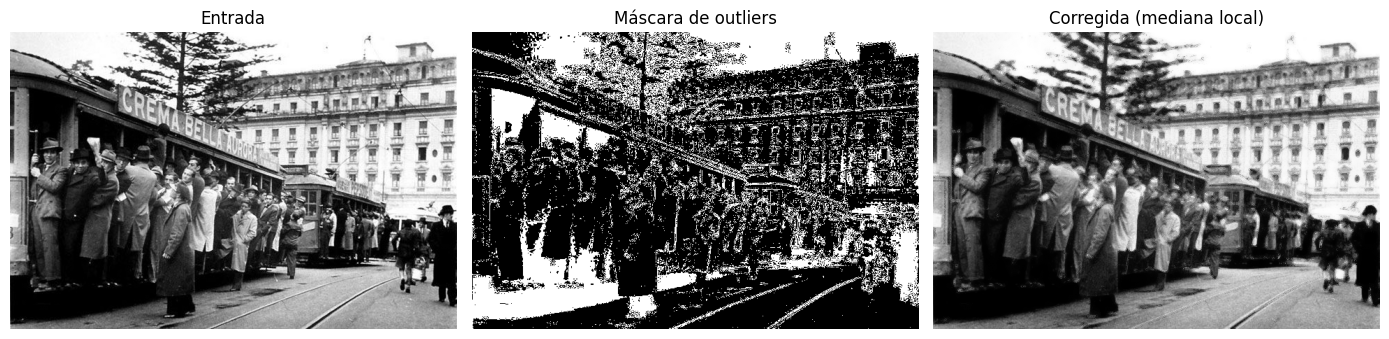

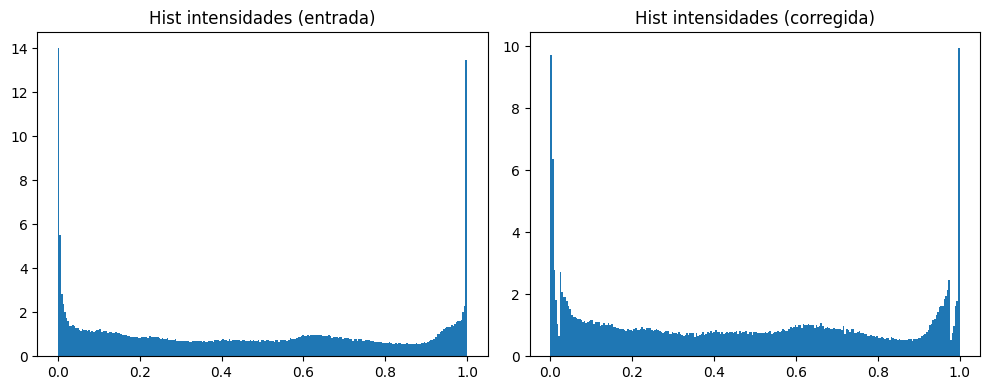

In [16]:
# Opción A: Subir imagen desde tu PC
path = choose_image()  # aparecerá el diálogo de subida

# Opción B: Usar ruta existente
# path = "/content/padre.jpg"

# Ejecuta (prueba sin simulación)
run_demo(path, simulate=False, K=300, show_color=False)

# Si tu imagen está "limpia", simula outliers para ver el flujo completo:
# run_demo(path, simulate=True, K=400, show_color=False)
